v1 column

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, 
    precision_score, recall_score, f1_score, roc_curve, 
    precision_recall_curve, roc_auc_score
)

Accuracy: 0.85
precision: 0.7945205479452054
recall: 0.6590909090909091
f1 score: 0.7204968944099379
Confusion Matrix:
[[197  15]
 [ 30  58]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       212
           1       0.79      0.66      0.72        88

    accuracy                           0.85       300
   macro avg       0.83      0.79      0.81       300
weighted avg       0.85      0.85      0.85       300



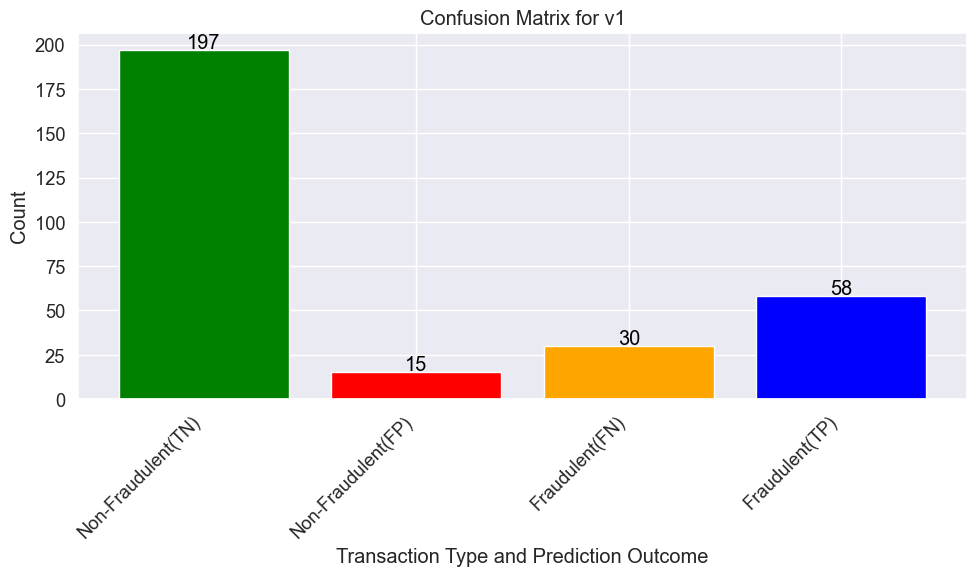

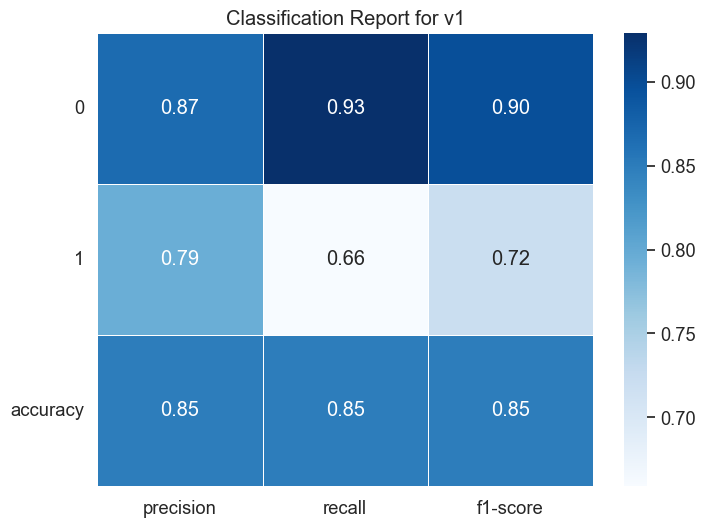

In [19]:
sns.set(font_scale=1.2)

# Load the dataset
original_dataset_path = 'creditcard.csv'
df = pd.read_csv(original_dataset_path)

# Preprocessing phase 
# Select columns
selected_columns = ['Time', 'V1', 'Amount', 'Class']
df_selected = df[selected_columns]

# Selection of 300 fraudulent transactions
df_fraud = df_selected[df_selected['Class'] == 1].sample(n=300, random_state=1)

# Selection of 700 non-fraudulent transactions
df_non_fraud = df_selected[df_selected['Class'] == 0].sample(n=700, random_state=1)

# Combining process of the selected samples
df_balanced = pd.concat([df_fraud, df_non_fraud])

# Split data into features and target
X_balanced = df_balanced[['Time', 'V1', 'Amount']]
y_balanced = df_balanced['Class']

# Split data into training and testing sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=1)

# Build the Random Forest model
model_balanced = RandomForestClassifier(random_state=1, n_estimators=100)
model_balanced.fit(X_train_balanced, y_train_balanced)

# Predictions on the test set
y_pred_balanced = model_balanced.predict(X_test_balanced)

# Evaluate the model
accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
precesion_balanced = precision_score(y_test_balanced, y_pred_balanced)
recall_balanced = recall_score(y_test_balanced, y_pred_balanced)
f1_balanced = f1_score(y_test_balanced, y_pred_balanced)

conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)
class_report_balanced = classification_report(y_test_balanced, y_pred_balanced)

# Print the results
print(f"Accuracy: {accuracy_balanced}")
print(f"precision: {precesion_balanced}")
print(f"recall: {recall_balanced}")
print(f"f1 score: {f1_balanced}")
print("Confusion Matrix:")
print(conf_matrix_balanced)
print("Classification Report:")
print(class_report_balanced)

# Visualization of the confusion matrix as a bar graph with updated labels and counts
labels = [
    'Non-Fraudulent(TN)', 
    'Non-Fraudulent(FP)', 
    'Fraudulent(FN)', 
    'Fraudulent(TP)'
]
counts = [conf_matrix_balanced[0, 0], conf_matrix_balanced[0, 1], conf_matrix_balanced[1, 0], conf_matrix_balanced[1, 1]]

plt.figure(figsize=(10, 6), dpi = 100)
bars = plt.bar(labels, counts, color=['green', 'red', 'orange', 'blue'])

# Add counts on top of the bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - (-1), f'{count}', ha='center', color='black')

plt.title('Confusion Matrix for v1')
plt.xlabel('Transaction Type and Prediction Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Get the classification report as a dictionary
report = classification_report(y_test_balanced, y_pred_balanced, output_dict=True)

# Convert the dictionary to a DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()

# Drop the 'support' column and the macro avg and weighted avg rows
report_df = report_df.drop(columns=['support'])
report_df = report_df.drop(['macro avg', 'weighted avg'])

# Plotting the heatmap
plt.figure(figsize=(8, 6), dpi = 100)
sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".2f", linewidths=.5)

plt.title('Classification Report for v1')
plt.yticks(rotation=0)
plt.show()



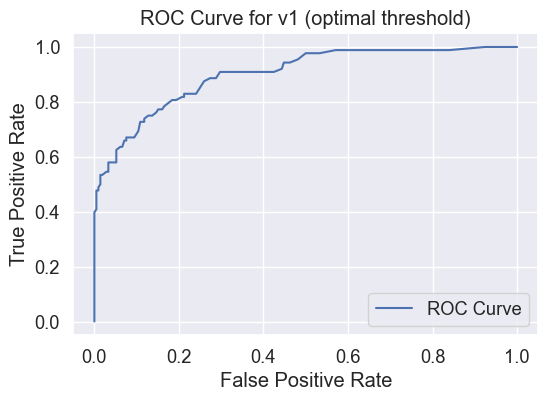

Best Threshold based on Accuracy: 0.54 with Accuracy: 0.85


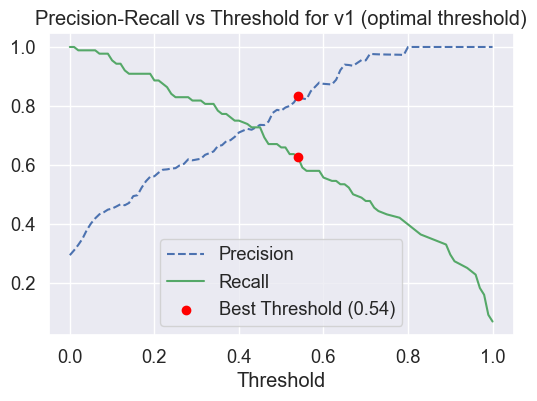

Accuracy with custom threshold: 0.8533333333333334
precision: 0.8333333333333334
recall: 0.625
f1 score: 0.7142857142857143
Confusion Matrix with custom threshold:
[[201  11]
 [ 33  55]]
Classification Report with custom threshold:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       212
           1       0.83      0.62      0.71        88

    accuracy                           0.85       300
   macro avg       0.85      0.79      0.81       300
weighted avg       0.85      0.85      0.85       300



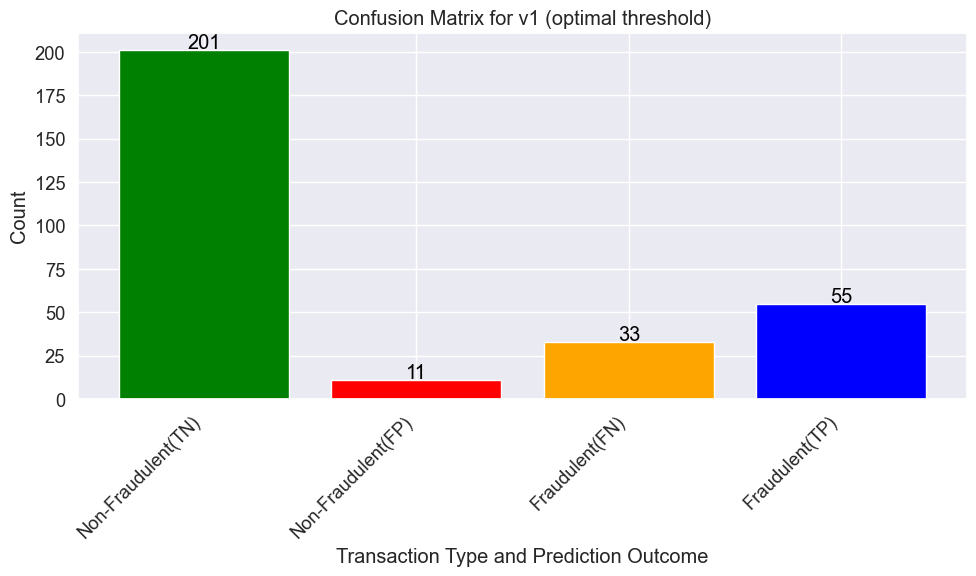

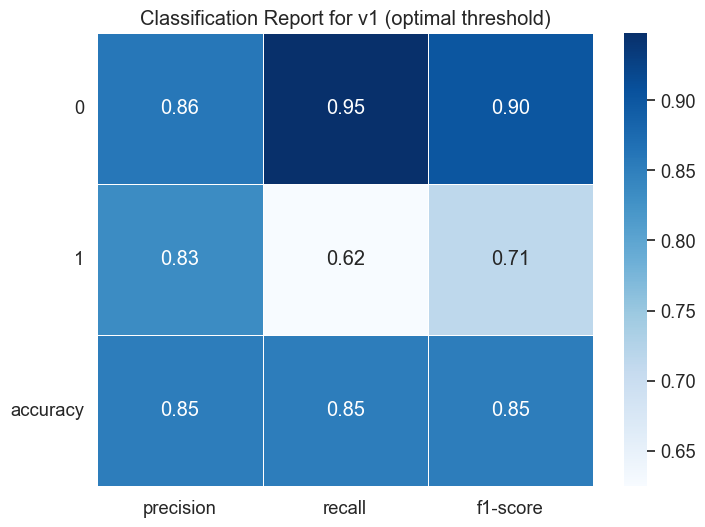

In [20]:
# Predict probabilities on the test set using the Random Forest model
y_probs_balanced = model_balanced.predict_proba(X_test_balanced)[:, 1] # type: ignore

# Plot ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test_balanced, y_probs_balanced)
plt.figure( dpi = 100)
plt.plot(fpr, tpr,label='ROC Curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for v1 (optimal threshold)")
plt.legend(loc="best")
plt.show()

# Plot Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_balanced, y_probs_balanced)

# Find the optimal threshold based on accuracy
thresholds_range = np.linspace(0, 1, num=100)
best_accuracy = 0
best_threshold = 0

for threshold in thresholds_range:
    y_pred_temp = (y_probs_balanced >= threshold).astype(int)
    current_accuracy = accuracy_score(y_test_balanced, y_pred_temp)
    
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_threshold = threshold

print(f"Best Threshold based on Accuracy: {best_threshold:.2f} with Accuracy: {best_accuracy:.2f}")

# Plot Precision-Recall Curve and highlight the best threshold
plt.figure( dpi = 100)
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "g-", label="Recall")

# Highlight the best threshold
optimal_idx_pr = np.argmin(np.abs(thresholds_pr - best_threshold))
plt.scatter(thresholds_pr[optimal_idx_pr], precision[optimal_idx_pr], color='red', label=f"Best Threshold ({best_threshold:.2f})", zorder=5)
plt.scatter(thresholds_pr[optimal_idx_pr], recall[optimal_idx_pr], color='red', zorder=5)

plt.xlabel("Threshold")
plt.title("Precision-Recall vs Threshold for v1 (optimal threshold)")
plt.legend(loc="best")
plt.show()

# Predict with the best threshold
y_pred_balanced_custom = (y_probs_balanced >= best_threshold).astype(int)

# Evaluate the model
accuracy_balanced_custom = accuracy_score(y_test_balanced, y_pred_balanced_custom)
precesion_balanced_custom = precision_score(y_test_balanced, y_pred_balanced_custom)
recall_balanced_custom = recall_score(y_test_balanced, y_pred_balanced_custom)
f1_balanced_custom = f1_score(y_test_balanced, y_pred_balanced_custom)
conf_matrix_balanced_custom = confusion_matrix(y_test_balanced, y_pred_balanced_custom)
class_report_balanced_custom = classification_report(y_test_balanced, y_pred_balanced_custom)

# Print the results
print(f"Accuracy with custom threshold: {accuracy_balanced_custom}")
print(f"precision: {precesion_balanced_custom}")
print(f"recall: {recall_balanced_custom}")
print(f"f1 score: {f1_balanced_custom}")
print("Confusion Matrix with custom threshold:")
print(conf_matrix_balanced_custom)
print("Classification Report with custom threshold:")
print(class_report_balanced_custom)


# Visualization of the confusion matrix as a bar graph with updated labels and counts
labels = [
    'Non-Fraudulent(TN)', 
    'Non-Fraudulent(FP)', 
    'Fraudulent(FN)', 
    'Fraudulent(TP)'
]
counts = [conf_matrix_balanced_custom[0, 0], conf_matrix_balanced_custom[0, 1], conf_matrix_balanced_custom[1, 0], conf_matrix_balanced_custom[1, 1]]

plt.figure(figsize=(10, 6), dpi = 100)
bars = plt.bar(labels, counts, color=['green', 'red', 'orange', 'blue'])

# Add counts on top of the bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - (-1), f'{count}', ha='center', color='black')

plt.title('Confusion Matrix for v1 (optimal threshold)')
plt.xlabel('Transaction Type and Prediction Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Get the classification report as a dictionary
report = classification_report(y_test_balanced, y_pred_balanced_custom, output_dict=True)

# Convert the dictionary to a DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()

# Drop the 'support' column and the macro avg and weighted avg rows
report_df = report_df.drop(columns=['support'])
report_df = report_df.drop(['macro avg', 'weighted avg'])

# Plotting the heatmap
plt.figure(figsize=(8, 6), dpi = 100)
sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".2f", linewidths=.5)

plt.title('Classification Report for v1 (optimal threshold)')
plt.yticks(rotation=0)
plt.show()

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Score: 0.8342857142857143
Accuracy: 0.8566666666666667
precision: 0.835820895522388
recall: 0.6363636363636364
f1 score: 0.7225806451612903
Confusion Matrix:
[[201  11]
 [ 32  56]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       212
           1       0.84      0.64      0.72        88

    accuracy                           0.86       300
   macro avg       0.85      0.79      0.81       300
weighted avg       0.85      0.86      0.85       300



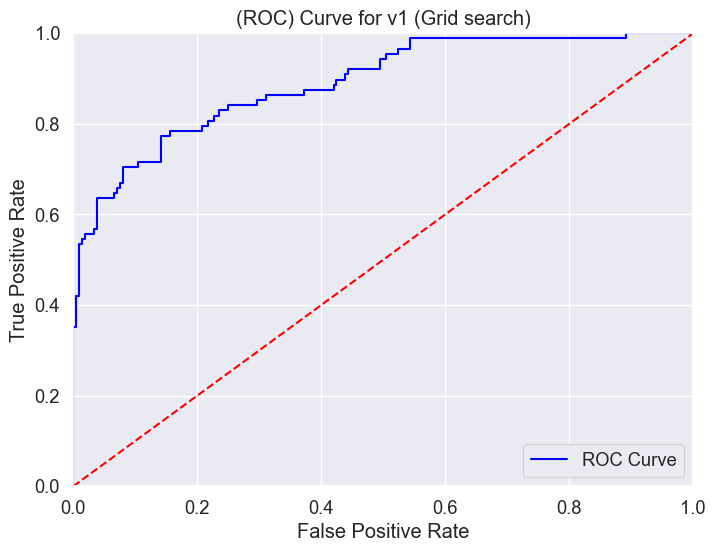

In [21]:
# Load the dataset
original_dataset_path = 'creditcard.csv'
df = pd.read_csv(original_dataset_path)

# Preprocessing phase 
# Select columns
selected_columns = ['Time', 'V1', 'Amount', 'Class']
df_selected = df[selected_columns]

# Selection of 300 fraudulent transactions
df_fraud = df_selected[df_selected['Class'] == 1].sample(n=300, random_state=1)

# Selection of 700 non-fraudulent transactions
df_non_fraud = df_selected[df_selected['Class'] == 0].sample(n=700, random_state=1)

# Combining process of the selected samples
df_balanced = pd.concat([df_fraud, df_non_fraud])

# Split data into features and target
X_balanced = df_balanced[['Time', 'V1', 'Amount']]
y_balanced = df_balanced['Class']

# Split data into training and testing sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=1)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [3, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3]  # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=1)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Train the Random Forest model with the best parameters
best_model = grid_search.best_estimator_
y_pred_balanced = best_model.predict(X_test_balanced) # type: ignore

# Evaluate the model
accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
precesion_balanced = precision_score(y_test_balanced, y_pred_balanced)
recall_balanced = recall_score(y_test_balanced, y_pred_balanced)
f1_balanced = f1_score(y_test_balanced, y_pred_balanced)

conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)
class_report_balanced = classification_report(y_test_balanced, y_pred_balanced)

# Print the results
print(f"Accuracy: {accuracy_balanced}")
print(f"precision: {precesion_balanced}")
print(f"recall: {recall_balanced}")
print(f"f1 score: {f1_balanced}")
print("Confusion Matrix:")
print(conf_matrix_balanced)
print("Classification Report:")
print(class_report_balanced)

# Compute the ROC curve and ROC AUC score
y_prob_balanced = best_model.predict_proba(X_test_balanced)[:, 1]   # type: ignore
fpr, tpr, thresholds = roc_curve(y_test_balanced, y_prob_balanced)
roc_auc = roc_auc_score(y_test_balanced, y_prob_balanced)

# Plot the ROC curve
plt.figure(figsize=(8, 6), dpi = 100)
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('(ROC) Curve for v1 (Grid search)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


v2 columns ----------------------------------------------------------------------------------------------

Accuracy: 0.8833333333333333
precision: 0.8354430379746836
recall: 0.75
f1 score: 0.7904191616766467
Confusion Matrix:
[[199  13]
 [ 22  66]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       212
           1       0.84      0.75      0.79        88

    accuracy                           0.88       300
   macro avg       0.87      0.84      0.85       300
weighted avg       0.88      0.88      0.88       300



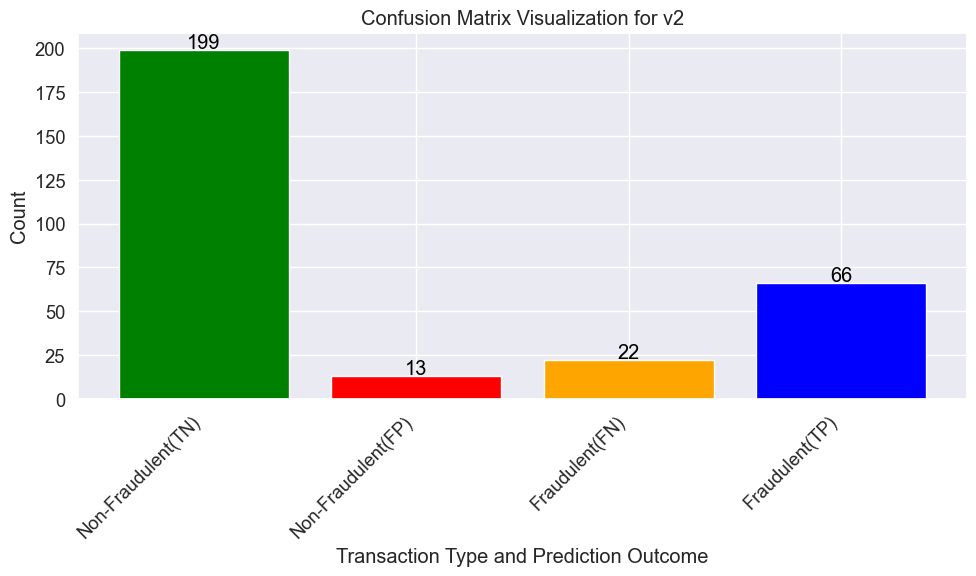

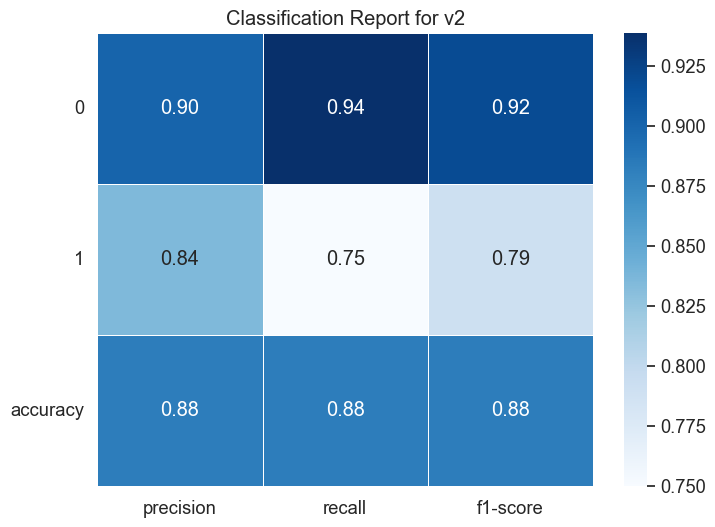

In [22]:
# Load the dataset
original_dataset_path = 'creditcard.csv'
df = pd.read_csv(original_dataset_path)

# Preprocessing phase 
# Select columns
selected_columns = ['Time', 'V2', 'Amount', 'Class']
df_selected = df[selected_columns]

# Selection of 300 fraudulent transactions
df_fraud = df_selected[df_selected['Class'] == 1].sample(n=300, random_state=1)

# Selection of 700 non-fraudulent transactions
df_non_fraud = df_selected[df_selected['Class'] == 0].sample(n=700, random_state=1)

# Combining process of the selected samples
df_balanced = pd.concat([df_fraud, df_non_fraud])

# Split data into features and target
X_balanced = df_balanced[['Time', 'V2', 'Amount']]
y_balanced = df_balanced['Class']

# Split data into training and testing sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=1)

# Build the Random Forest model
model_balanced = RandomForestClassifier(random_state=1, n_estimators=100)
model_balanced.fit(X_train_balanced, y_train_balanced)

# Predictions on the test set
y_pred_balanced = model_balanced.predict(X_test_balanced)

# Evaluate the model
accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
precesion_balanced = precision_score(y_test_balanced, y_pred_balanced)
recall_balanced = recall_score(y_test_balanced, y_pred_balanced)
f1_balanced = f1_score(y_test_balanced, y_pred_balanced)

conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)
class_report_balanced = classification_report(y_test_balanced, y_pred_balanced)

# Print the results
print(f"Accuracy: {accuracy_balanced}")
print(f"precision: {precesion_balanced}")
print(f"recall: {recall_balanced}")
print(f"f1 score: {f1_balanced}")
print("Confusion Matrix:")
print(conf_matrix_balanced)
print("Classification Report:")
print(class_report_balanced)

# Visualization of the confusion matrix as a bar graph with updated labels and counts
labels = [
    'Non-Fraudulent(TN)', 
    'Non-Fraudulent(FP)', 
    'Fraudulent(FN)', 
    'Fraudulent(TP)'
]
counts = [conf_matrix_balanced[0, 0], conf_matrix_balanced[0, 1], conf_matrix_balanced[1, 0], conf_matrix_balanced[1, 1]]

plt.figure(figsize=(10, 6), dpi = 100)
bars = plt.bar(labels, counts, color=['green', 'red', 'orange', 'blue'])

# Add counts on top of the bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - (-1), f'{count}', ha='center', color='black')

plt.title('Confusion Matrix Visualization for v2')
plt.xlabel('Transaction Type and Prediction Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Get the classification report as a dictionary
report = classification_report(y_test_balanced, y_pred_balanced, output_dict=True)

# Convert the dictionary to a DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()

# Drop the 'support' column and the macro avg and weighted avg rows
report_df = report_df.drop(columns=['support'])
report_df = report_df.drop(['macro avg', 'weighted avg'])

# Plotting the heatmap
plt.figure(figsize=(8, 6), dpi = 100)
sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".2f", linewidths=.5)

plt.title('Classification Report for v2')
plt.yticks(rotation=0)
plt.show()



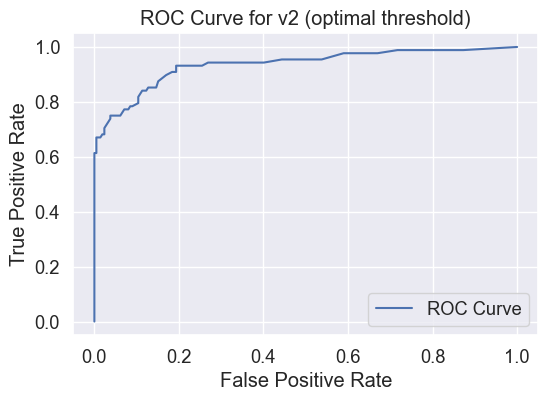

Best Threshold based on Accuracy: 0.57 with Accuracy: 0.90


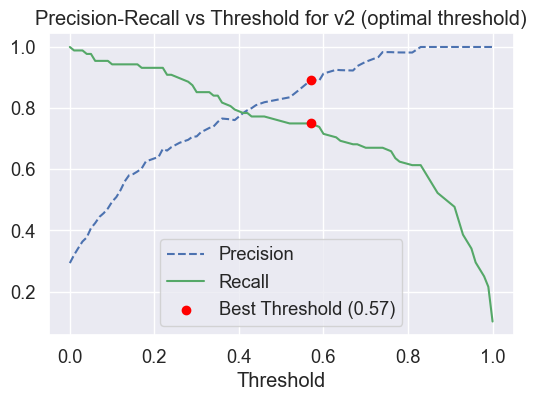

Accuracy with custom threshold: 0.9
precision: 0.8918918918918919
recall: 0.75
f1 score: 0.8148148148148148
Confusion Matrix with custom threshold:
[[204   8]
 [ 22  66]]
Classification Report with custom threshold:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       212
           1       0.89      0.75      0.81        88

    accuracy                           0.90       300
   macro avg       0.90      0.86      0.87       300
weighted avg       0.90      0.90      0.90       300



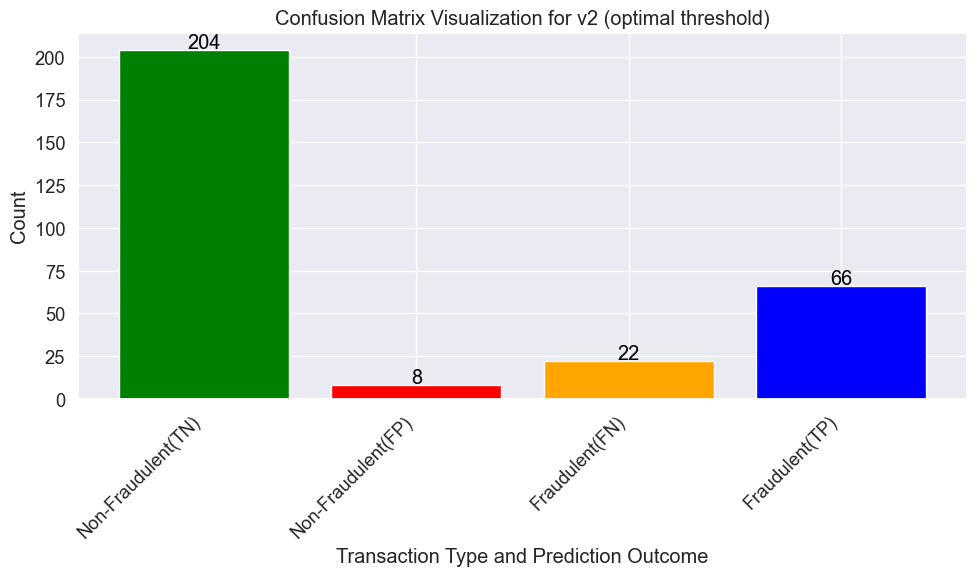

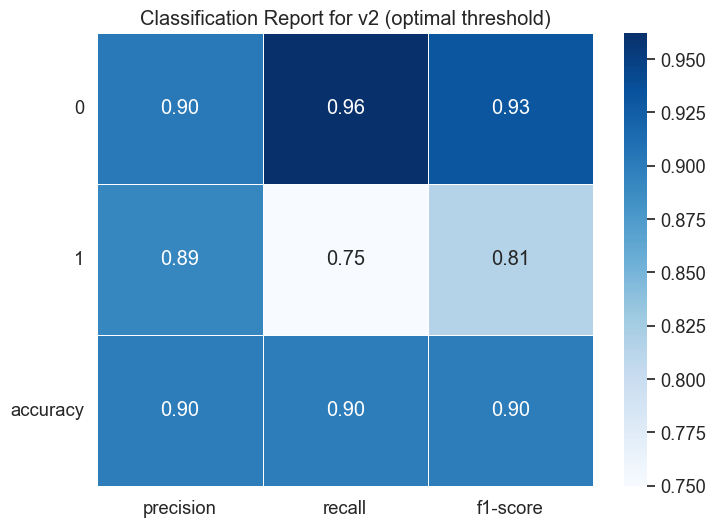

In [23]:
# Predict probabilities on the test set using the Random Forest model
y_probs_balanced = model_balanced.predict_proba(X_test_balanced)[:, 1] # type: ignore

# Plot ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test_balanced, y_probs_balanced)
plt.figure( dpi = 100)
plt.plot(fpr, tpr,label=f'ROC Curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for v2 (optimal threshold)")
plt.legend(loc="best")
plt.show()

# Plot Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_balanced, y_probs_balanced)

# Find the optimal threshold based on accuracy
thresholds_range = np.linspace(0, 1, num=100)
best_accuracy = 0
best_threshold = 0

for threshold in thresholds_range:
    y_pred_temp = (y_probs_balanced >= threshold).astype(int)
    current_accuracy = accuracy_score(y_test_balanced, y_pred_temp)
    
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_threshold = threshold

print(f"Best Threshold based on Accuracy: {best_threshold:.2f} with Accuracy: {best_accuracy:.2f}")

# Plot Precision-Recall Curve and highlight the best threshold
plt.figure( dpi = 100)
plt.plot(thresholds_pr, precision[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recall[:-1], "g-", label="Recall")

# Highlight the best threshold
optimal_idx_pr = np.argmin(np.abs(thresholds_pr - best_threshold))
plt.scatter(thresholds_pr[optimal_idx_pr], precision[optimal_idx_pr], color='red', label=f"Best Threshold ({best_threshold:.2f})", zorder=5)
plt.scatter(thresholds_pr[optimal_idx_pr], recall[optimal_idx_pr], color='red', zorder=5)

plt.xlabel("Threshold")
plt.title("Precision-Recall vs Threshold for v2 (optimal threshold)")
plt.legend(loc="best")
plt.show()

# Step 5: Predict with the best threshold
y_pred_balanced_custom = (y_probs_balanced >= best_threshold).astype(int)

# Step 6: Evaluate the model
accuracy_balanced_custom = accuracy_score(y_test_balanced, y_pred_balanced_custom)
precesion_balanced_custom = precision_score(y_test_balanced, y_pred_balanced_custom)
recall_balanced_custom = recall_score(y_test_balanced, y_pred_balanced_custom)
f1_balanced_custom = f1_score(y_test_balanced, y_pred_balanced_custom)
conf_matrix_balanced_custom = confusion_matrix(y_test_balanced, y_pred_balanced_custom)
class_report_balanced_custom = classification_report(y_test_balanced, y_pred_balanced_custom)

# Print the results
print(f"Accuracy with custom threshold: {accuracy_balanced_custom}")
print(f"precision: {precesion_balanced_custom}")
print(f"recall: {recall_balanced_custom}")
print(f"f1 score: {f1_balanced_custom}")
print("Confusion Matrix with custom threshold:")
print(conf_matrix_balanced_custom)
print("Classification Report with custom threshold:")
print(class_report_balanced_custom)

# Visualization of the confusion matrix as a bar graph with updated labels and counts
labels = [
    'Non-Fraudulent(TN)', 
    'Non-Fraudulent(FP)', 
    'Fraudulent(FN)', 
    'Fraudulent(TP)'
]
counts = [conf_matrix_balanced_custom[0, 0], conf_matrix_balanced_custom[0, 1], conf_matrix_balanced_custom[1, 0], conf_matrix_balanced_custom[1, 1]]

plt.figure(figsize=(10, 6), dpi = 100)
bars = plt.bar(labels, counts, color=['green', 'red', 'orange', 'blue'])

# Add counts on top of the bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - (-1), f'{count}', ha='center', color='black')

plt.title('Confusion Matrix Visualization for v2 (optimal threshold)')
plt.xlabel('Transaction Type and Prediction Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Get the classification report as a dictionary
report = classification_report(y_test_balanced, y_pred_balanced_custom, output_dict=True)

# Convert the dictionary to a DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()

# Drop the 'support' column and the macro avg and weighted avg rows
report_df = report_df.drop(columns=['support'])
report_df = report_df.drop(['macro avg', 'weighted avg'])

# Plotting the heatmap
plt.figure(figsize=(8, 6), dpi = 100)
sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".2f", linewidths=.5)

plt.title('Classification Report for v2 (optimal threshold)')
plt.yticks(rotation=0)
plt.show()

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Score: 0.8714285714285713
Accuracy: 0.8866666666666667
precision: 0.8552631578947368
recall: 0.7386363636363636
f1 score: 0.7926829268292682
Confusion Matrix:
[[201  11]
 [ 23  65]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       212
           1       0.86      0.74      0.79        88

    accuracy                           0.89       300
   macro avg       0.88      0.84      0.86       300
weighted avg       0.88      0.89      0.88       300



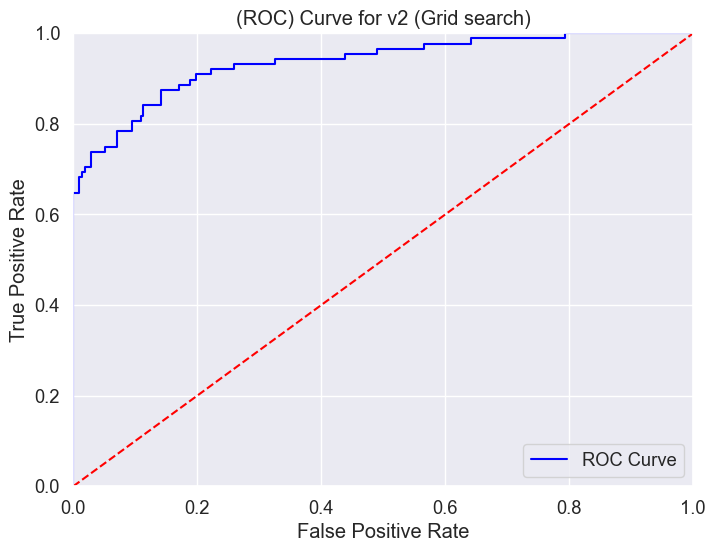

In [24]:
# Load the dataset
original_dataset_path = 'creditcard.csv'
df = pd.read_csv(original_dataset_path)

# Preprocessing phase 
# Select columns
selected_columns = ['Time', 'V2', 'Amount', 'Class']
df_selected = df[selected_columns]

# Selection of 300 fraudulent transactions
df_fraud = df_selected[df_selected['Class'] == 1].sample(n=300, random_state=1)

# Selection of 700 non-fraudulent transactions
df_non_fraud = df_selected[df_selected['Class'] == 0].sample(n=700, random_state=1)

# Combining process of the selected samples
df_balanced = pd.concat([df_fraud, df_non_fraud])

# Split data into features and target
X_balanced = df_balanced[['Time', 'V2', 'Amount']]
y_balanced = df_balanced['Class']

# Split data into training and testing sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=1)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [3, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3]  # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=1)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

# Train the Random Forest model with the best parameters
best_model = grid_search.best_estimator_
y_pred_balanced = best_model.predict(X_test_balanced) # type: ignore

# Evaluate the model
accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
precesion_balanced = precision_score(y_test_balanced, y_pred_balanced)
recall_balanced = recall_score(y_test_balanced, y_pred_balanced)
f1_balanced = f1_score(y_test_balanced, y_pred_balanced)

conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)
class_report_balanced = classification_report(y_test_balanced, y_pred_balanced)

# Print the results
print(f"Accuracy: {accuracy_balanced}")
print(f"precision: {precesion_balanced}")
print(f"recall: {recall_balanced}")
print(f"f1 score: {f1_balanced}")
print("Confusion Matrix:")
print(conf_matrix_balanced)
print("Classification Report:")
print(class_report_balanced)

# Compute the ROC curve and ROC AUC score
y_prob_balanced = best_model.predict_proba(X_test_balanced)[:, 1]   # type: ignore
fpr, tpr, thresholds = roc_curve(y_test_balanced, y_prob_balanced)
roc_auc = roc_auc_score(y_test_balanced, y_prob_balanced)

# Plot the ROC curve
plt.figure(figsize=(8, 6), dpi = 100)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('(ROC) Curve for v2 (Grid search)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
